\begin{center}
Cameron Flannery \\
UID: 804449742
\end{center}
\
<font color='red'>__NOTE TO THE READER:__</font> This document was created inline with the code. All the code that was used to analyze the data and generate the plots can be seen directly above the plots. Therefore, there may be large breaks in between sections where there is significant code.

## Abstract

A Kalman Filter was implemented to determine the bias in an accelerometer using asynchronous GPS data. By using the orthogonal projection lemma, a Kalman filter algorithm was derived that is able to achieve a steady-state estimate of the bias value in much less than 30 seconds. To prove the algorithm, a Monte Carlo Simulation was run with 10000 iterations. The results show that the expected error in the position, velocity, and time approaches zero.

## Introduction

We are presented with a $\:50 Hz\:$ accelerometer with an unknown bias value. Using a known acceleration profile, and measurements from a $\:2 Hz\:$ GPS.

$$ a(t) = a\sin{(\Omega t)} \: m/s $$

Where $a = 10$ and $\Omega = 0.1 rad/s$.

Integrating the simulation model yields equations for velocity and position.

$$ v(t) = v(0) + \frac{a}{\Omega} - \frac{a}{\Omega}\cos{(\Omega t)} $$
$$ p(t) = p(0) + (v(0) + \frac{a}{\Omega})t - \frac{a}{\Omega^2} \sin{(\Omega t)} $$

### Acceleration Model

The corrupted acceleration profile is given by

$$ a_c(t) = a(t) + b + w(t) $$

Where $b$ is the constant bias value and $w(t)$ is zero mean, white noise process.

Difference equations for the corrupted system can be derived using the Euler integration formulas.

$$ v_c(t_{i+1}) = v_c(t_{i}) + a_c(t_{i}) \Delta t $$
$$ p_c(t_{i+1}) = p_c(t_{i}) + v_c(t_{i}) \Delta t + a_c(t_{i}) \frac{\Delta t^2}{2} $$

with initial conditions $v_c(0) = \bar{v}_0$ and $p_c(0) = \bar{p}_0 =0$ 

### Derivation of Dynamic Model
In order to discretize the truth model, we make the assumption that the true acceleration is integrated by the same Euler integration formula as our corrupted state from the accelerometer.

$$ v_E(t_{i+1}) = v_E(t_{i}) + a(t_{i}) \Delta t $$
$$ p_E(t_{i+1}) = p_E(t_{i}) + v_E(t_{i}) \Delta t + a(t_{i}) \frac{\Delta t^2}{2} $$

with initial statistics $v(0) = v_E(0)\approx N(\bar{v}_0, M_0^v)$ and $p(0) = p_E(0) \approx N(\bar{p}_0,M_0^p).$ 

The dynamics for the system are obtained by subtracting the corrupted state from the Euler approximation of the true state. This yields the dynamic equations in the standard form.

$$ x_{k+1} = \Phi x_k + \Gamma w_k $$ <br>
$$\Phi = \begin{bmatrix} 1 & \Delta t & -\frac{\Delta t^2}{2}\\0 & 1 & -\Delta t\\0 & 0 & 1\end{bmatrix}$$ <br>
$$\Gamma = \begin{bmatrix} \frac{-\Delta t^2}{2}\\-\Delta t\\0 \end{bmatrix}$$ <br>
$$x_k = \begin{bmatrix} \delta p_E(t_k) \\ \delta v_E({t_k}) \\ b_k\end{bmatrix}$$

Where the state transition, $\Phi$, and noise transition, $\Gamma$, matricies are time-invariant, and
$$\delta p_E(0) = p_E(0) - p_c(0) \approx N(0,M_0^p)$$
$$\delta v_E(0) = v_E(0) - v_c(0) \approx N(0,M_0^v)$$
$$b(0) \approx N(0, M_0^b)$$

$\Delta t$ is defined as the time step of the fastest measurement. In this case, the accelerometer updates at 50 Hz. Therefore, $\Delta t = 0.02 s$

### Measurement Equations

The GPS measurement process is defined by

$$z^p(t_i) = p(t_i) + \eta^p(t_i)$$
$$z^v(t_i) = v(t_i) + \eta^v(t_i)$$

where $\:p(t_i)\:$ is the position and $\:v(t_i)\:$ is the velocity at time $t_i$ and $\eta^p$ and $\eta^v$ are Gaussian zero mean, white noise processes.

Based on on formulation of the state as the state error, it is necessary to define $\delta z$.

$$\delta z^p(t_i) = \delta p(t_i) + \eta^p(t_i)$$
$$\delta z^v(t_i) = \delta v(t_i) + \eta^v(t_i)$$

Statistics for the initial conditions and the zero-mean, white noise processes are provided below. All white-noise processes are independent and Gaussian.

$$x_0 \approx N(0m, 100m^2)$$
$$v_0 \approx N(100 m/s, 1 (m/s)^2)$$
$$w(t_i) = N(0,0.0001(m/s)^2)$$
$$b(t_i) \approx N(0,0.1(m/s^2)^2)$$
$$\eta^p(t_i) = N(0,1m^2)$$
$$\eta^v(t_i) = N(0,0.0016(m/s)^2)$$

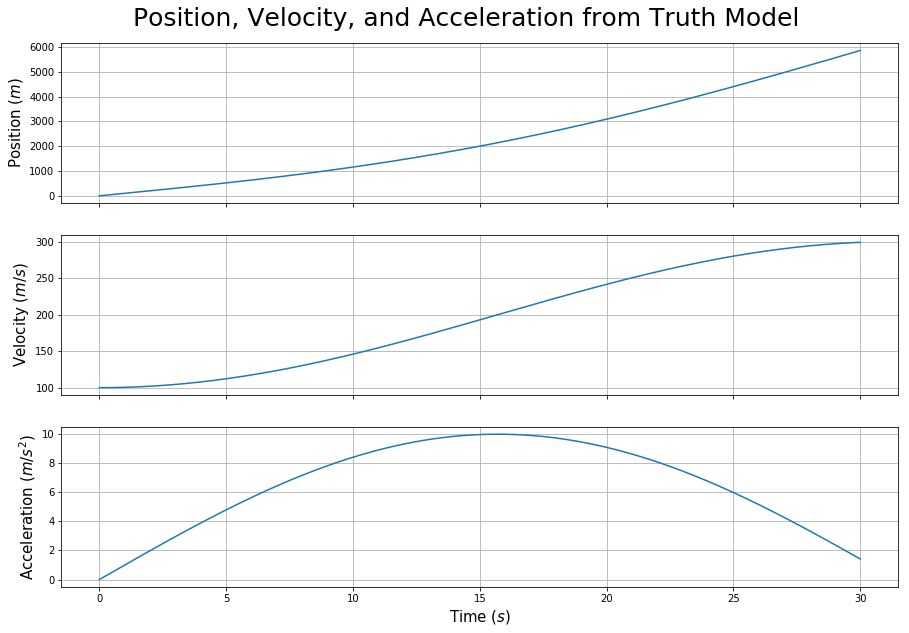

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


fsize = 15

time_of_sim = 30  # s
freq_acc = 50  # frequency of accelerometer measurements
freq_meas = 2
dt = 1./freq_acc
dt_meas = 1./freq_meas

time_steps_acc = freq_acc*time_of_sim+1
time_steps_meas = freq_meas*time_of_sim+1
time = np.linspace(0, time_of_sim, time_steps_acc)
time_meas = np.linspace(0, time_of_sim, time_steps_meas)

Omega = 0.1
a_truth = 10*np.sin(0.1*time)

v_truth = np.zeros(time_steps_acc)
x_truth = np.zeros(time_steps_acc)

v_truth[0] = 100
x_truth[0] = 0

for idx in range(1,len(time)):
    v_truth[idx] = dt*a_truth[idx-1] + v_truth[idx-1]
    x_truth[idx] = dt*dt*a_truth[idx-1]/2. + v_truth[idx-1]*dt + x_truth[idx-1]

    
fig, ax = plt.subplots(3,1,sharex=True,figsize=(15,10))

ax[0].plot(time, x_truth)
ax[0].set_ylabel('Position $(m)$',size=fsize)

ax[1].plot(time, v_truth)
ax[1].set_ylabel('Velocity $(m/s)$',size=fsize)

ax[2].plot(time, a_truth)
ax[2].set_ylabel('Acceleration $(m/s^2)$',size=fsize)
ax[2].set_xlabel('Time $(s)$', size=fsize)

fig.suptitle('Position, Velocity, and Acceleration from Truth Model',size=25,y=0.93)

for i in range(0,3):
    ax[i].grid()

plt.show()

## Theory and Algorithm

In order to determine the error due to the accelerometer bias, it is beneficial to define the state as the position error, the velocity error, and the estimated bias as we did in the derivation of the dynamics model above.

The orthogonal projection lemma is used to derive the Kalman Filter. The Kalman filter could have been derived for this problem using conditional means, however, the author prefers OPL as it is a more general algorithm that applies to non-Gaussian problems in additional to the more limited class of Gauss-Markov problems. The Kalman filtering equation and update formulas for the covariances and Kalman Gain are shown below.

Since the GPS and accelerometer measure at difference frequencies, different update equations must be determined based on whether or not the GPS measurements are available.

### Kalman Filter with GPS Measurement Updates

#### Updating the Kalman Filter Gain and the a posteriori state
$$ K_k = M_k H^T[HM_kH^T + V_k]^{-1} $$
$$ \hat{x}_k = \bar{x}_{k-1} + K_k(y_k - H\Phi x_{k-1}) $$

#### Update the Error Covariances
$$ P_k = (I - K_kH_k)M_k $$
$$ M_{k+1} = \Phi_{k}P_{k}\Phi_{k}^T + \Gamma_{k}W_{k}\Gamma_{k} $$

### Accelerometer Only Update
$$ \bar{x}_k = \Phi \bar{x}_{k-1} $$
$$ M_{k+1} = \Phi_{k}M_{k}\Phi_{k}^T + \Gamma_{k}W_{k}\Gamma_{k} $$

## Results and Performance
The code below performes $10000$ simulations, each with a different bias generated based on the a priori statistics stated in the introduction section.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


Nsimulations = 10000

ns = 3  # number of states
no = 2  # number of outputs

error_x = np.zeros((time_steps_acc,Nsimulations))
error_v = np.zeros((time_steps_acc,Nsimulations))
error_bias = np.zeros((time_steps_acc,Nsimulations))


for k in range(0,Nsimulations):
    # calculate the bias
    b = np.random.normal(0, np.sqrt(0.01))

    # Define the acceleration from the model
    # start by defining a white noise process
    w = np.random.normal(0, np.sqrt(0.0001),size=(time_steps_acc))

    # corrupted state values
    ac = np.zeros((time_steps_acc,1))
    ac[:,0] = (a_truth + b + w).T

    vc = np.zeros((time_steps_acc,1))
    vc[0] = v_truth[0]

    xc = np.zeros((time_steps_acc,1))
    xc[0] = x_truth[0]
    for idx in range(1,len(time)):
        vc[idx] = dt*ac[idx-1,0] + vc[idx-1,0]
        xc[idx] = dt*dt*ac[idx-1,0]/2. + dt*vc[idx-1,0] + xc[idx-1,0]

    # stochastic simulation
    # state is error position, error velocity, bias
    state = np.zeros((ns,1,time_steps_acc))  
    z = np.zeros((no,1,time_steps_acc))
    residual = np.zeros((no,1,time_steps_acc))
    
    P = np.zeros((ns,ns,time_steps_acc))
    M = np.zeros((ns,ns,time_steps_acc))
    K = np.zeros((ns,no,time_steps_acc))

    V = np.array([[1,0],[0,0.0016]])
    H = np.array([[1,0,0],[0,1,0]])
    W = 0.0004

    Gamma = np.zeros((ns,1))  # Gamma is not time-varying
    Gamma[:,0] = np.array([dt**2/2.,dt,0])

    Phi = np.array([[1,dt,-dt**2/2.],[0,1,-dt],[0,0,1]])

    I = np.eye(ns)

    # initialize matricies
    M[:,:,0] = np.array([[1,0,0],[0,0.04,0],[0,0,np.sqrt(0.01)]])
    igps = []
    for i in range(0,len(time)-1):
        if time[i]%(1./freq_meas) == 0:
            # Update covariances
            igps.append(i)
            K[:,:,i] = np.matmul(np.matmul(M[:,:,i],H.T),
                                 np.linalg.inv(np.matmul(
                                     H,np.matmul(M[:,:,i],H.T))))
            P[:,:,i] = np.matmul((I-np.matmul(K[:,:,i],H)),M[:,:,i])

            # measure the things
            z_x = x_truth[i] - xc[i] + np.random.normal(0,1)
            z_v = v_truth[i] - vc[i] + np.random.normal(0,0.04)
            z[:,:,i] = np.array([z_x,z_v])

            # update the state
            residual[:,:,i] = z[:,:,i] - \
                              np.matmul(H,np.matmul(Phi[:,:],state[:,:,i-1]))
            state[:,:,i] = np.matmul(Phi[:,:],state[:,:,i-1]) + \
                           np.matmul(K[:,:,i],residual[:,:,i])

            M[:,:,i+1] = np.matmul(np.matmul(Phi[:,:],P[:,:,i]),Phi[:,:].T) + \
                                   np.matmul(Gamma*W,Gamma.T)
        else:
            # if no measurement at current time step, update the a priori covariance
            state[:,:,i] = np.matmul(Phi[:,:], state[:,:,i-1])
            M[:,:,i+1] = np.matmul(np.matmul(Phi[:,:],M[:,:,i]),Phi[:,:].T) + \
                                   np.matmul(Gamma*W,Gamma.T)
    
    # propogate the last state
    i += 1
    state[:,:,i] = np.matmul(Phi[:,:], state[:,:,i-1])
    
    error_x[:,k] = x_truth - np.squeeze(xc) - np.squeeze(state[0,0,:])
    error_v[:,k] = v_truth - np.squeeze(vc) - np.squeeze(state[1,0,:])
    error_bias[:,k] = np.ones(len(x_truth))*b - np.squeeze(state[2,0,:])

ave_error_x = 1./Nsimulations*np.sum(error_x,axis=1)
ave_error_v = 1./Nsimulations*np.sum(error_v,axis=1)
ave_error_bias = 1./Nsimulations*np.sum(error_bias,axis=1)

The results for a single realization of the simulation are plotted below. As expected, the estimated bias value tends towards the true value, while the position and velocity error terms accumulate over time.

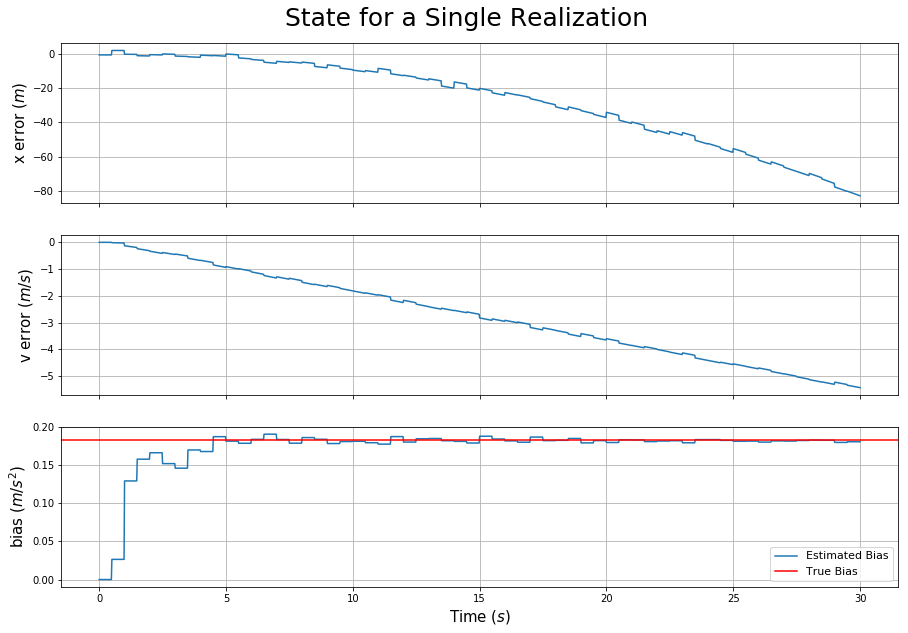

In [3]:
# plotting things
fig, ax = plt.subplots(3,1,sharex=True,figsize=(15,10))

fsize = 15
ax[0].plot(time,np.squeeze(state[0,:,:]))
ax[0].set_ylabel('x error $(m)$',size=fsize)

ax[1].plot(time,np.squeeze(state[1,:,:]))
ax[1].set_ylabel('v error $(m/s)$',size=fsize)

ax[2].plot(time,np.squeeze(state[2,:,:]))
ax[2].axhline(y=b,color='r')
ax[2].set_xlabel('Time $(s)$',size=fsize)
ax[2].set_ylabel('bias $(m/s^2)$',size=fsize)
ax[2].legend(['Estimated Bias', 'True Bias'], prop={'size': 11})

fig.suptitle('State for a Single Realization',size=25,y=0.93)

for i in range(0,3):
    ax[i].grid()

plt.show()

### Filtered Position, Velocity, and Acceleration for a Single Realization

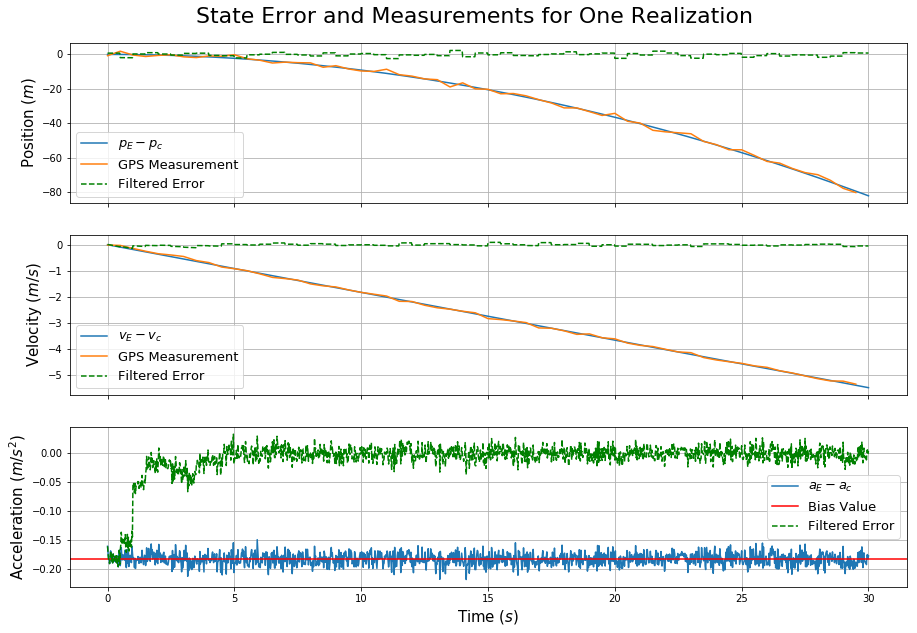

In [4]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(15,10))

# extract the gps measurements
idx_meas = np.where(z[0,0,:] != 0)
z1 = z[0,0,idx_meas]
z2 = z[1,0,idx_meas]
time_gps = time[idx_meas]

ax[0].plot(time, x_truth-np.squeeze(xc))
ax[0].plot(time_gps, np.squeeze(z1))
ax[0].plot(time, x_truth-np.squeeze(xc)-np.squeeze(state[0,:,:]), '--g')
ax[0].set_ylabel('Position $(m)$',size=fsize)
ax[0].legend(['$p_E-p_c$', 'GPS Measurement', 'Filtered Error'], prop={'size': 13})


ax[1].plot(time, v_truth-np.squeeze(vc))
ax[1].plot(time_gps, np.squeeze(z2))
ax[1].plot(time, v_truth-np.squeeze(vc)-np.squeeze(state[1,:,:]), '--g')
ax[1].set_ylabel('Velocity $(m/s)$',size=fsize)
ax[1].legend(['$v_E-v_c$', 'GPS Measurement', 'Filtered Error'], prop={'size': 13})

ax[2].plot(time, a_truth-np.squeeze(ac))
ax[2].axhline(y=-b, color='r')
ax[2].plot(time, a_truth-np.squeeze(ac)+np.squeeze(state[2,:,:]), '--g')
ax[2].set_ylabel('Acceleration $(m/s^2)$',size=fsize)
ax[2].set_xlabel('Time $(s)$', size=fsize)
ax[2].legend(['$a_E-a_c$', 'Bias Value', 'Filtered Error'], prop={'size': 13})


fig.suptitle('State Error and Measurements for One Realization',size=22,y=0.93)

for i in range(0,3):
    ax[i].grid()

plt.show()

### Monte Carlo Averaged Error

We expect the ensamble averaged estimated position, velocity, and bias error to be close to zero. The estimation error is defined as the true state less the corrupted state and the calculated error.

$$ \bar{e}_k = \delta x_k - \bar{\delta x}_k $$
$$e^{ave} = \frac{1}{N_{ave}} \sum^{N_{ave}}_{l=1} e^{l}_k $$

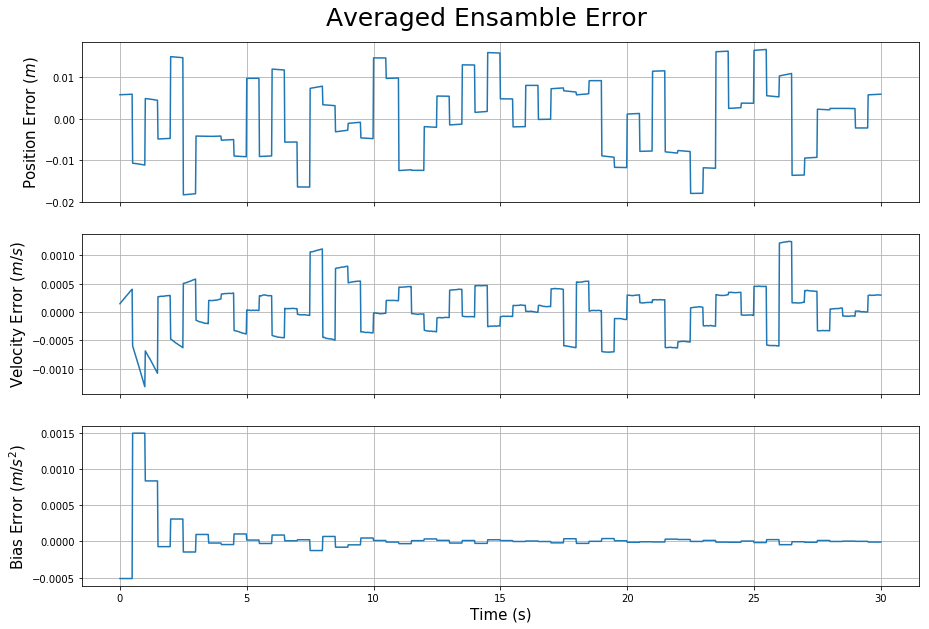

In [7]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(15,10))

ax[0].plot(time, ave_error_x)
ax[0].set_ylabel('Position Error $(m)$', size=fsize)
ax[1].plot(time, ave_error_v)
ax[1].set_ylabel('Velocity Error $(m/s)$', size=fsize)
ax[2].plot(time, ave_error_bias)
ax[2].set_ylabel('Bias Error $(m/s^2)$', size=fsize)
ax[2].set_xlabel('Time (s)', size=fsize)

fig.suptitle('Averaged Ensamble Error',size=25,y=0.93)

for i in range(0,3):
    ax[i].grid()

plt.show()

It is clear from the figure above that the ensamble averaged error is approximately zero for each of the states. However, further checks need to be evoked to evaluate the performance of the Kalman Filter.

Therefore, we have validated that $e^{ave}_k \approx 0 \: \forall \:k \:\in\: [0,30]$.

### Kalman Gain Evolution

It is intesting to see how the Kalman gain evolves for a single realization.

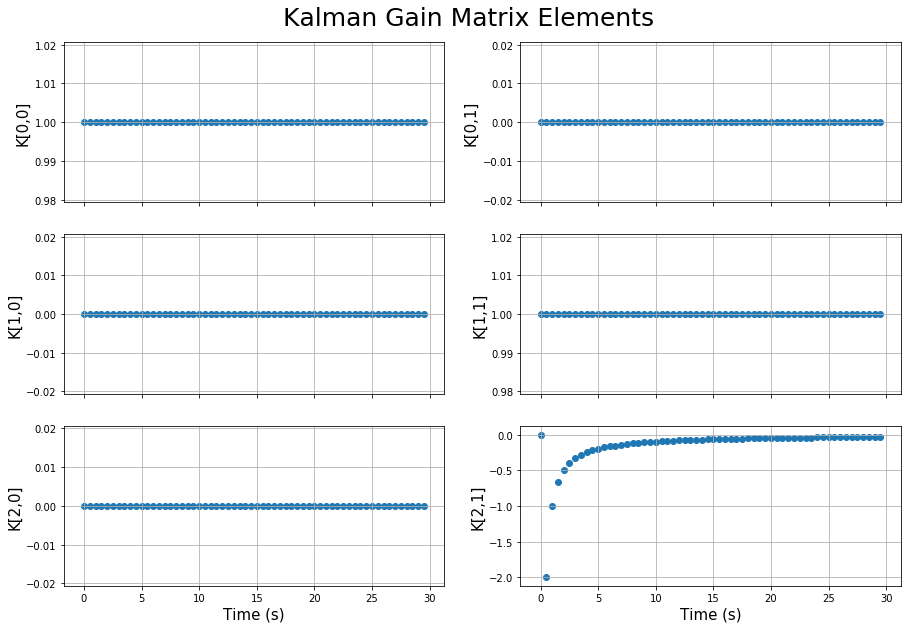

In [9]:
Kidx = np.where(K[0,0,:]!=0)
Kgain = K[:,:,Kidx]
t_idx = time[Kidx]

fig, ax = plt.subplots(3,2,sharex=True,figsize=(15,10))

ax[0,0].scatter(t_idx, np.squeeze(Kgain[0,0,:]))
ax[0,0].set_ylabel('K[0,0]', size=fsize)
ax[1,0].scatter(t_idx, np.squeeze(Kgain[1,0,:]))
ax[1,0].set_ylabel('K[1,0]', size=fsize)
ax[0,1].scatter(t_idx, np.squeeze(Kgain[0,1,:]))
ax[0,1].set_ylabel('K[0,1]', size=fsize)
ax[1,1].scatter(t_idx, np.squeeze(Kgain[1,1,:]))
ax[1,1].set_ylabel('K[1,1]', size=fsize)
ax[2,1].scatter(t_idx, np.squeeze(Kgain[2,1,:]))
ax[2,1].set_xlabel('Time (s)', size=fsize)
ax[2,1].set_ylabel('K[2,1]', size=fsize)
ax[2,0].scatter(t_idx, np.squeeze(Kgain[2,0,:]))
ax[2,0].set_ylabel('K[2,0]', size=fsize)
ax[2,0].set_xlabel('Time (s)', size=fsize)

fig.suptitle('Kalman Gain Matrix Elements',size=25,y=0.93)

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].grid()

plt.show()

Although not immediately intuitive, the top block of the Kalman gain matrix is the identity matrix. This is because we are defining our measurements as the error between the euler integrated velocity and position and the accelerometer measured. Since the corruption in the accelerometer and GPS measurements is a zero-mean white noise process, the bias is the driving influence in our measurements and is the only term that the Kalman filter needs to correct. The orthogonality checks that follow further confirm the validity of our Kalman filter derivation.

### Error Variance

The ensamble average produces the average error variance, $P^{ave}$.

$$ P^{ave}_k = \frac{1}{N_{ave}-1} \sum_{l=t}^{N_{ave}}[e^l_k - e^{ave}_k][e^l_k-e^{ave}_k]^T $$

where $N_{ave} - 1$ is used for an unbiased variance from sample theory. An important check for the validity of the Kalman filter is the difference between the ensamble average variance and the variance for a single Kalman Filter realization.

$$ P^{ave}_k - P_k \approx 0 $$

This is computed below, where $P_k$ is the error variance for a single realization.

In [14]:
j = 0
k = 1

Pave = np.zeros((ns,ns,time_steps_acc))  # error variance averaged over all runs
Peach = np.zeros((ns,ns,time_steps_acc,Nsimulations))  # error variances for each simulation
error_P = np.zeros((ns,ns,time_steps_acc,Nsimulations))
error_P_mean = np.zeros((ns,ns,time_steps_acc))

for idx_t, current_time in enumerate(time):
    for idx_sim in range(0,Nsimulations):
        el = np.array([[error_x[idx_t,idx_sim],error_v[idx_t,idx_sim],
                        error_bias[idx_t,idx_sim]]])
        el_ave = np.array([[ave_error_x[idx_t],ave_error_v[idx_t],
                            ave_error_bias[idx_t]]])
        
        Peach[:,:,idx_t,idx_sim] = np.matmul((el-el_ave).T,(el-el_ave))
        Pave[:,:,idx_t] += 1./Nsimulations*Peach[:,:,idx_t,idx_sim]
        error_P[:,:,idx_t,idx_sim] = Pave[:,:,idx_t] - Peach[:,:,idx_t,idx_sim]
        error_P_mean[:,:,idx_t] += 1./Nsimulations*error_P[:,:,idx_t,idx_sim]

With the error variances calculated for each time step and simulation, and the average error variance determined, it is possible to determine the difference between the error betweeen the average error variance and the single realization error variance. We expect difference to be approximately zero when averaged over a signifiant number of runs.

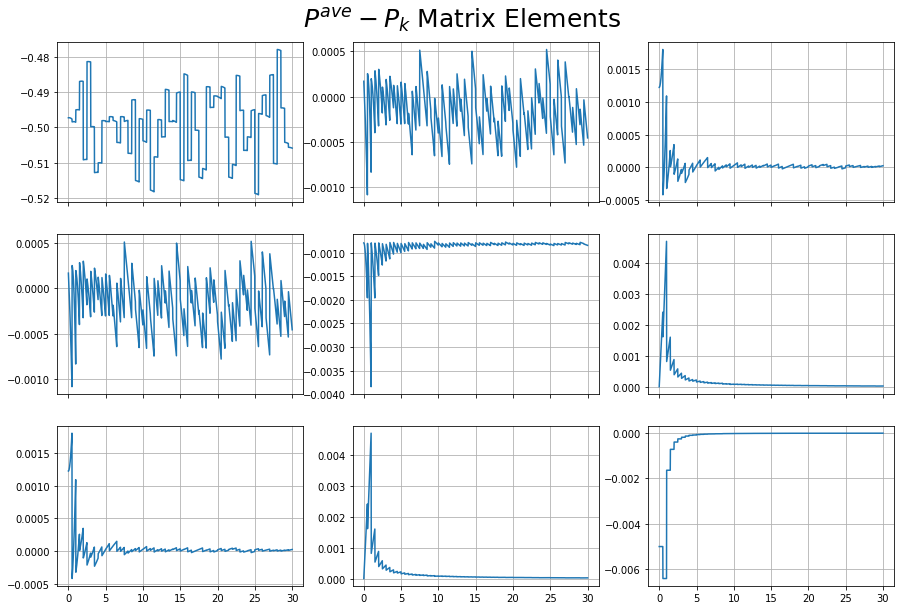

In [15]:
fig, ax = plt.subplots(3,3,sharex=True,figsize=(15,10))

fig.suptitle('$P^{ave}-P_k$ Matrix Elements',size=25,y=0.93)

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].grid()
        ax[i,j].plot(time, np.squeeze(error_P_mean[i,j,:]))

plt.show()

### Orthogonality

In addition to allowing the derivation of the Kalman Filter for non-Gaussian systems, the Orthogonal Projection Lemma provides some important insights.

Namely,
1. The estimation error is orthogonal to the measurement history.
2. The estimation error is orthogonal to the estimated value.
3. The residual term is independent of the measurement history.
4. The residual term is zero mean.

Insights 2-3 can be derived from 1 after some manipulation.

First, we will verify that the estimation error is approximately orthogonal to the estimated value.

Specifically,

$$ E[(x_k-\hat{x}_k)\hat{x}_i^T] \approx 0 \: \forall \: i $$

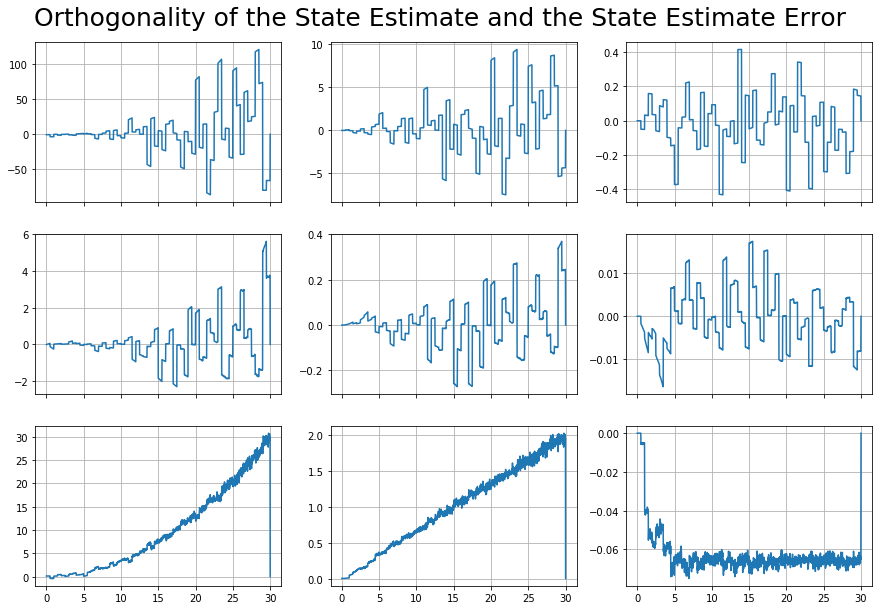

In [58]:
true_state = np.zeros((ns,1,time_steps_acc))
true_state[0,0,:] = np.squeeze(x_truth)-np.squeeze(xc)
true_state[1,0,:] = np.squeeze(v_truth)-np.squeeze(vc)
true_state[2,0,:] = np.squeeze(a_truth)-np.squeeze(ac)

orthogonality_check = np.zeros((ns,ns,time_steps_acc))
k = time_steps_acc-1
for i in range(0,k):
    orthogonality_check[:,:,i] = np.matmul((np.squeeze(true_state[:,:,i])-
                                            np.squeeze(state[:,:,i]))[:,np.newaxis],state[:,:,i].T)

fig, ax = plt.subplots(3,3,sharex=True,figsize=(15,10))
fig.suptitle('Orthogonality of the State Estimate and the State Estimate Error',size=25,y=0.93)

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].plot(time, np.squeeze(orthogonality_check[i,j,:]))
        ax[i,j].grid()
plt.show()

The plot above indicates that the estimated state is approximately orthogonal to the error in the state estimation as expected. The significant magnitude in the (2,1) and (2,2) element of the correlation matrix is likely a result of the white noise processes. This was confirmed by varying the white noise processes and seeing a resulting increase or decrease in the magnitude of the (2,1) element.

As a last check, we need to verify the independence of the residual, or innovations process, term. This is again computed with an auto-correlation function.

$$ \frac{1}{N_{ave}-1} \sum_{l=t}^{N_{ave}}r^l_k(r^l_m)^T \: \forall \: m < k$$

The correlation of the residuals is evaluated at a single single choice of $m$ and $k$ below.

In [14]:
np.matmul(residual[:,:,igps[4]],residual[:,:,igps[1]].T)

array([[ 1.78660142, -0.10870455],
       [ 0.03995234, -0.00243087]])

As expected, the resdiual is uncorrelated, as the autocorrelation value is close to zero.

## Conclusion

The Kalman filter, derived here with the orthogonal projection lemma, provides the best minimum variance estimator for the error accumulated in an accelerometer due to bias. It should be noted that, since the system is Gaussian, the filter could have been derived with a conditional mean estimator, however OPL provides a more generalized derivation, valid for both Guass-Markov and non-Gaussian, Markov systems that the author prefers. Additionally, the orthogonality properties of the Kalman Filter provide a useful metric for verifying the performance of a filter. 


In deriving the Kalman filter, we were able to fuse the measurements from the accelerometer with those of the GPS in order to come up with a more accurate position, velocity, and acceleration estimate. This simulation, however, was limited. In particular, the truth acceleration was a constant frequency. As a result, nothing can be said about the frequency response of the Kalman filter. Further testing should include sweeping over several frequencies to determine the filtering statistics under varying conditions.


Performing a Monte Carlo simulation of the system provides additional useful insight. In particular, assuming that the dynamic model provided is correct, and the error variances are accurate, simulating the performance of a system could provide key insights into the expected system performance. Stochastic simulations provide the use with statistical data to design chance-constrained controls system, the subject of my research. Stochastic simulations are invaluble for areas where intuition fails, or needs to be confirmed. 